<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/VAE_filled_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [58]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
data_dir = 'data'

batch_size = 128
image_size = 784

dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

In [ ]:
def plot_reconstruction(model, n=24):
  x,_ = next(iter(data_loader))
  x = x[:n,:,:,:].to(device)
  out, _, _, log_p = model_G(x.view(-1, image_size)) 
  x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
  out_grid = torchvision.utils.make_grid(x_concat).cpu().data
  show(out_grid)
  
def plot_generation(model, n=24):
  with torch.no_grad():
    z = torch.randn(n, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)

  out_grid = torchvision.utils.make_grid(out).cpu()
  show(out_grid)
  
def plot_conditional_generation(model, n=8, fix_number=None):
  
  with torch.no_grad():
  
    matrix = np.zeros((n,n_classes))
    matrix[:,0] = 1

    if fix_number is None:
      final = matrix[:]
      for i in range(1,n_classes):
        final = np.vstack((final,np.roll(matrix,i)))
      z = torch.randn(8*n_classes, z_dim).to(device)
      y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
      out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
    else:
      z = torch.randn(n, z_dim).to(device)
      y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
      out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

  out_grid = torchvision.utils.make_grid(out).cpu()
  show(out_grid)

# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instea maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$. The variational posterior $q_{\phi}(z|x)$ is also called the encoder and the generative model $p_{\theta}(x|z)$, the decoder or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), 1)$ the term $\log p_\theta(x|z)$ reduced to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0,1)$.

Variational Autoencoders were introduced by [Kingma and Welling](https://arxiv.org/abs/1312.6114), see also [Doersch](https://arxiv.org/abs/1606.05908) for a tutorial.

There are vairous examples of VAE in pytorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

In [ ]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu, log_var = self.fc2(h), self.fc3(h)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take BCE. The code below is still from the pytorch tutorial (with minor modifications to avoid warnings!).

In [ ]:
# Start training
def train(model, data_loader, num_epochs):
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(data_loader):
            
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                       .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

In [67]:
# Hyper-parameters
num_epochs = 10
learning_rate = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model ,data_loader, num_epochs=num_epochs)

Epoch[1/10], Step [100/469], Reconst Loss: 167.2587, KL Div: 10.4920
Epoch[1/10], Step [200/469], Reconst Loss: 139.1753, KL Div: 14.2874
Epoch[1/10], Step [300/469], Reconst Loss: 123.3982, KL Div: 18.5178
Epoch[1/10], Step [400/469], Reconst Loss: 109.1822, KL Div: 19.2442
Epoch[2/10], Step [100/469], Reconst Loss: 105.0116, KL Div: 21.0979
Epoch[2/10], Step [200/469], Reconst Loss: 102.0510, KL Div: 22.1501
Epoch[2/10], Step [300/469], Reconst Loss: 93.0679, KL Div: 22.3279
Epoch[2/10], Step [400/469], Reconst Loss: 96.2574, KL Div: 23.5266
Epoch[3/10], Step [100/469], Reconst Loss: 87.7377, KL Div: 24.1945
Epoch[3/10], Step [200/469], Reconst Loss: 91.0185, KL Div: 24.6380
Epoch[3/10], Step [300/469], Reconst Loss: 83.7119, KL Div: 23.9378
Epoch[3/10], Step [400/469], Reconst Loss: 95.0833, KL Div: 25.1792
Epoch[4/10], Step [100/469], Reconst Loss: 88.3221, KL Div: 24.5069
Epoch[4/10], Step [200/469], Reconst Loss: 86.8471, KL Div: 24.4897
Epoch[4/10], Step [300/469], Reconst Loss:

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

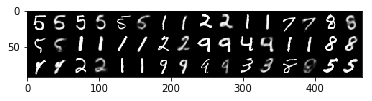

In [68]:
plot_reconstruction(model)

Let see now, how our network generates new samples.

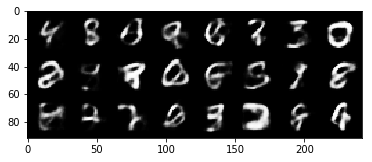

In [69]:
plot_generation(model)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this jupyter, we explore ways to generates zeros, ones, twos and so on. As a by product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NIPS [paper](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture...

The idea is that you incorporates a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planed, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation required us to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in this [paper](https://arxiv.org/abs/1611.01144). This is implemented in pytorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax)

In [ ]:
# CVAE model
class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(h_dim, n_classes)
        self.fc5 = nn.Linear(z_dim + n_classes, h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)        
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu, log_var, log_p = self.fc2(h), self.fc3(h), F.log_softmax(self.fc4(h), dim=1)
        return mu, log_var, log_p
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        latent = torch.cat((z, y_onehot),dim=1)
        h = F.relu(self.fc5(latent))
        x_reconst = torch.sigmoid(self.fc6(h))
        return x_reconst
    
    def forward(self, x):
        mu, log_var, log_p = self.encode(x)
        z = self.reparameterize(mu, log_var)
        y_onehot = F.gumbel_softmax(log_p)
        x_reconst = self.decode(z, y_onehot)
        #print(alpha)
        return x_reconst, mu, log_var, log_p

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in the NIPS [paper](https://arxiv.org/abs/1804.00104)

In [ ]:
def train_G(model, data_loader, num_epochs, verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, log_p = model(x)
            p = torch.exp(log_p)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            p_uniform = 1/n_classes * torch.ones_like(p)
            entropy = torch.sum(p * torch.log(p / p_uniform))

            # Backprop and optimize
            loss = reconst_loss + kl_div + entropy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 100 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, entropy.item()/batch_size))

In [73]:
# Hyper-parameters
num_epochs = 10
learning_rate = 1e-3

model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

train_G(model_G, data_loader, num_epochs=num_epochs)

Epoch[1/10], Step [100/469], Reconst Loss: 177.0880, KL Div: 10.7395, Entropy: 0.0243
Epoch[1/10], Step [200/469], Reconst Loss: 145.8061, KL Div: 15.0224, Entropy: 0.0184
Epoch[1/10], Step [300/469], Reconst Loss: 126.1062, KL Div: 16.1145, Entropy: 0.0256
Epoch[1/10], Step [400/469], Reconst Loss: 111.4432, KL Div: 19.2571, Entropy: 0.0243
Epoch[2/10], Step [100/469], Reconst Loss: 102.0065, KL Div: 19.7116, Entropy: 0.0177
Epoch[2/10], Step [200/469], Reconst Loss: 100.1450, KL Div: 20.7308, Entropy: 0.0152
Epoch[2/10], Step [300/469], Reconst Loss: 101.0175, KL Div: 21.7898, Entropy: 0.0166
Epoch[2/10], Step [400/469], Reconst Loss: 95.2303, KL Div: 21.0075, Entropy: 0.0158
Epoch[3/10], Step [100/469], Reconst Loss: 94.0175, KL Div: 22.5559, Entropy: 0.0235
Epoch[3/10], Step [200/469], Reconst Loss: 97.3338, KL Div: 22.2687, Entropy: 0.0358
Epoch[3/10], Step [300/469], Reconst Loss: 90.3443, KL Div: 21.6698, Entropy: 0.0308
Epoch[3/10], Step [400/469], Reconst Loss: 96.1604, KL Div

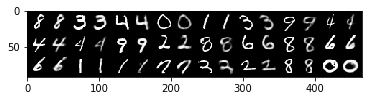

In [74]:
plot_reconstruction(model)

This was for reconstruction, but we care more about generation. For each category, we may generate n=8 samples with the plot_conditional_generation() function. We expect that on each line only one digit should be represented.

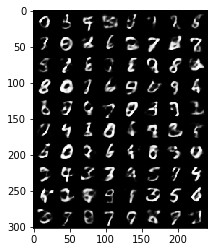

In [76]:
plot_conditional_generation(model, n=8)

It does not look like our original idea is working...

What is happening is that our network is not using the categorical variable. We can track the [normalized mutual information](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) between the true labels and the labels 'predicted' by our network (just by taking the category with maximal probability). 

Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

This problem is explained in this [paper](https://arxiv.org/abs/1804.03599) and a solution is proposed in Section 5.

In order to force our network to use the categorical variable, we will change the loss according to this [paper](https://arxiv.org/abs/1804.00104), Section 3 equation (7).

Implement this change in the training loop and plot the new NMI curve. For $\beta = 20, C_z=100, C_c=100$, you should see that NMI increases.

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

def train_G_modified_loss(model, data_loader, num_epochs, beta=1 , C_z_fin=0, C_c_fin=0, verbose=True):
    nmi_scores = []
    model.train(True)
    NMI_history = []
    for epoch in range(num_epochs):
        
        C_z = C_z_fin * epoch/num_epochs
        C_c = C_c_fin * epoch/num_epochs
        
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, log_p = model(x)
            p = torch.exp(log_p)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            p_uniform = 1/n_classes * torch.ones_like(p)
            entropy = torch.sum(p * torch.log(p / p_uniform))
            NMI = normalized_mutual_info_score(labels.cpu().numpy(), p.cpu().max(1)[1].numpy())
            NMI_history.append(NMI)
            
            # Backprop and optimize
            loss = reconst_loss + beta * ( abs(kl_div - C_z) + abs(entropy - C_c) )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 100 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, entropy.item()/batch_size))
                    print('NMI : ',NMI)
            
    return NMI_history

Epoch[1/10], Step [100/469], Reconst Loss: 204.3492, KL Div: 0.0453, Entropy: 0.0002
NMI :  0.3076857960431328
Epoch[1/10], Step [200/469], Reconst Loss: 204.4883, KL Div: 0.0769, Entropy: 0.0002
NMI :  0.36358884328589325
Epoch[1/10], Step [300/469], Reconst Loss: 207.7939, KL Div: 0.1264, Entropy: 0.0002
NMI :  0.33439690482793055
Epoch[1/10], Step [400/469], Reconst Loss: 202.2956, KL Div: 0.1432, Entropy: 0.0002
NMI :  0.33221084941227774
Epoch[2/10], Step [100/469], Reconst Loss: 202.4620, KL Div: 0.2124, Entropy: 0.1399
NMI :  0.34421028757205385
Epoch[2/10], Step [200/469], Reconst Loss: 204.8331, KL Div: 0.1772, Entropy: 0.1688
NMI :  0.34171722862362086
Epoch[2/10], Step [300/469], Reconst Loss: 201.2416, KL Div: 0.1845, Entropy: 0.1953
NMI :  0.34486529858306414
Epoch[2/10], Step [400/469], Reconst Loss: 190.5109, KL Div: 0.1702, Entropy: 0.1967
NMI :  0.32593506180467147
Epoch[3/10], Step [100/469], Reconst Loss: 183.2862, KL Div: 0.3096, Entropy: 0.3654
NMI :  0.39691172364

Text(0, 0.5, 'NMI')

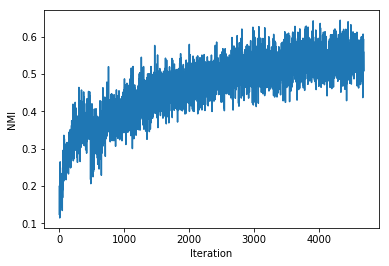

In [124]:
import warnings
warnings.filterwarnings('ignore') 

# Hyper-parameters
num_epochs = 10
learning_rate = 1e-3
beta = 20
C_z_fin=200
C_c_fin=200

model_G = VAE_Gumbel(z_dim = z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

NMI = train_G_modified_loss(model_G, data_loader, num_epochs=num_epochs, beta=beta, C_z_fin=C_z_fin, C_c_fin=C_c_fin)
plt.plot(NMI)
plt.xlabel('Iteration')
plt.ylabel('NMI')

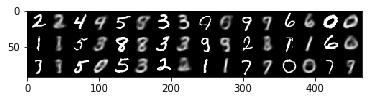

In [125]:
plot_reconstruction(model_G)

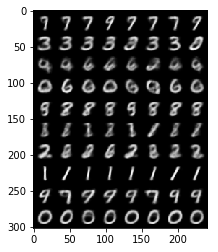

In [126]:
plot_conditional_generation(model_G, fix_number=None)

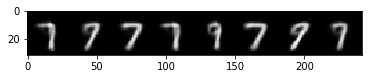

In [128]:
plot_conditional_generation(model_G, fix_number=0)

# Cheating by using labels

In [ ]:
from sklearn.metrics import normalized_mutual_info_score

def train_G_labels(model, data_loader, num_epochs, beta=1, verbose=True):
    nmi_scores = []
    model.train(True)
    NMI_history = []
    for epoch in range(num_epochs):
        
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            labels = labels.to(device)
            x_reconst, mu, log_var, log_p = model(x)
            p = torch.exp(log_p)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            NMI = normalized_mutual_info_score(labels.cpu().numpy(), p.cpu().max(1)[1].numpy())
            NMI_history.append(NMI)
            
            label_loss = F.nll_loss(log_p, labels)
            
            # Backprop and optimize
            loss = reconst_loss + kl_div + beta * label_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 100 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Label Loss: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div.item()/batch_size, label_loss/batch_size))
                    print('NMI : ',NMI)
            
    return NMI_history

Epoch[1/5], Step [100/469], Reconst Loss: 153.4338, KL Div: 9.6792, Label Loss: 0.0311
NMI :  0.40702262003917394
Epoch[1/5], Step [200/469], Reconst Loss: 128.3498, KL Div: 13.8679, Label Loss: 0.0341
NMI :  0.554841343527284
Epoch[1/5], Step [300/469], Reconst Loss: 119.6462, KL Div: 13.9471, Label Loss: 0.0312
NMI :  0.5192419598672995
Epoch[1/5], Step [400/469], Reconst Loss: 104.9183, KL Div: 13.9203, Label Loss: 0.0276
NMI :  0.517094650044023
Epoch[2/5], Step [100/469], Reconst Loss: 106.9439, KL Div: 16.0072, Label Loss: 0.0314
NMI :  0.5659834755254812
Epoch[2/5], Step [200/469], Reconst Loss: 100.2957, KL Div: 15.8726, Label Loss: 0.0323
NMI :  0.5230336578936262
Epoch[2/5], Step [300/469], Reconst Loss: 103.1252, KL Div: 16.2006, Label Loss: 0.0357
NMI :  0.5015199566898173
Epoch[2/5], Step [400/469], Reconst Loss: 106.4009, KL Div: 16.0166, Label Loss: 0.0356
NMI :  0.5435394010933847
Epoch[3/5], Step [100/469], Reconst Loss: 98.2339, KL Div: 15.5890, Label Loss: 0.0294
NMI

Text(0, 0.5, 'NMI')

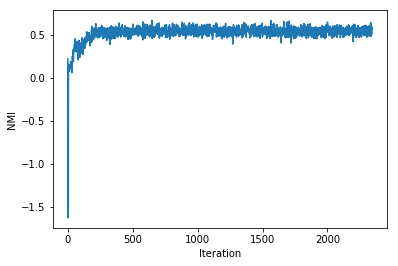

In [40]:
n_classes = 10
learning_rate = 0.01
model_G = VAE_Gumbel(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

NMI = train_G_labels(model_G, data_loader, num_epochs=5, beta=10, verbose=True)
plt.plot(NMI)
plt.xlabel('Iteration')
plt.ylabel('NMI')

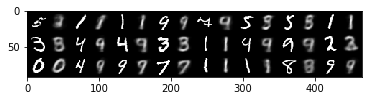

In [85]:
plot_reconstruction(model_G)

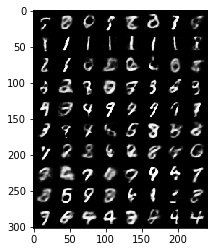

In [37]:
plot_conditional_generation(model_G)

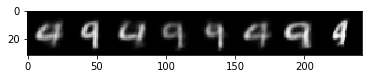

In [107]:
plot_conditional_generation(model_G, fix_number=1)